In [1]:
# import 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import os, glob, math
from datetime import datetime
import re


import warnings
warnings.filterwarnings('ignore')

In [2]:
# import 
import pandas as pd
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
import seaborn as sns

import os, glob, joblib
from tqdm import tqdm
from datetime import datetime
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score ,roc_curve, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

---
## KLARF file parsing

In [3]:
dir_path = "/home/seon/workspace/project/anomaly_wafer_detection/klarfsample_v3/C"
file_path = os.path.join(dir_path, '*.001')
path_list = glob.glob(file_path)
len(path_list)

23

In [4]:
# 실행할 때마다 한 줄씩 읽어오기
# readlines()로 한번에 시도하면, 용량이 큰 파일의 경우엔 out of memory 가능성.

def readfile(file_path):
    readlines = []
    with open(file_path, 'r') as f:
        i = 1
        while True:
            line = f.readline()
            if not line:
                break
            if line[0] == ' ':
                line = line.strip(' ')
            line = str(i) + ' ' + line
            readlines.append(line.strip('\n').strip(';').split(' '))
            i += 1    
    return readlines

readfile(path_list[0])

[['1', 'FileVersion', '1', '1'],
 ['2', 'FileTimestamp', '03-13-23', '11:47:31'],
 ['3', 'TiffSpec', '6.0', '', '', '', '', 'G', '', '', '', '', 'R'],
 ['4', 'InspectionStationID', '"Hynix"', '"FIB"', '"M10C2D01"'],
 ['5', 'SampleType', 'WAFER'],
 ['6', 'SampleSize', '1', '300'],
 ['7', 'Scan', 'type', 'Surface'],
 ['8', 'ResultTimestamp', '02-27-23', '01:12:48'],
 ['9', 'LotID', '"T7HJ400T"'],
 ['10', 'DeviceID', '"V7H_REFLOW_INSP3"'],
 ['11', 'SetupID', '"FINAL"', '02-27-23', '01:07:42'],
 ['12', 'StepID', '"WAFER_REFLOW_INSP3"'],
 ['13', 'ResultsID', '"V7H_REFLOW_INSP3"'],
 ['14', 'WaferID', '"T7HJ400-21"'],
 ['15', 'Slot', '21'],
 ['16', 'SampleOrientationMarkType', 'FLAT'],
 ['17', 'OrientationMarkLocation', 'DOWN'],
 ['18', 'OrientationInstruction', 'DOWN'],
 ['19', 'SampleCenterLocation', '122858.907', '5007.85200000001'],
 ['20', 'DiePitch', '10236', '10574'],
 ['21', 'CoordinatesMirrored', 'YES'],
 ['22', 'DieOrigin', '0.000000', '0.000000'],
 ['23', 'ClassLookup', '254'],
 ['

### KLARF file의 설비, 제품 및 시간에 대한 데이터 parsing

In [5]:
# KLARF file로부터 데이터 parsing
temp_df = pd.DataFrame()
fname = []
for i, fp in enumerate(path_list):
    dict_klarf = {}
    for line in readfile(fp):
        if not line[1].lstrip('-').isnumeric():
            dict_klarf[line[1]] = ' '.join(line[2:])
    fname.append(os.path.splitext(os.path.basename(fp))[0])
    temp = pd.DataFrame(dict_klarf, index=[i])
    temp_df = pd.concat([temp_df, temp])

temp_df.columns = temp_df.columns.str.lower()
temp_df['filename'] = fname
cols = ['filename']
cols.extend(temp_df.columns[:-1])

temp_df = temp_df[cols]
temp_df.head(3)

,filename,fileversion,filetimestamp,tiffspec,inspectionstationid,sampletype,samplesize,scan,resulttimestamp,lotid,...,sampletestplan,areapertest,defectrecordspec,defectlist,summaryspec,testno,summarylist,endoffile,,tifffilename
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,1 1,03-13-23 11:47:31,6.0 G R,"""Hynix"" ""FIB"" ""M10C2D01""",WAFER,1 300,type Surface,02-27-23 01:12:48,"""T7HJ400T""",...,439,47515368696,16 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5,NDEFECT DEFDENSITY NDIE NDEFDIE,,,NaN,NaN
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,1 1,03-13-23 11:46:36,6.0 G R,"""Hynix"" ""FIB"" ""M10C2D01""",WAFER,1 300,type Surface,02-27-23 00:40:33,"""T7HJ400T""",...,435,47082426840,16 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5,NDEFECT DEFDENSITY NDIE NDEFDIE,,,NaN,NaN
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,1 1,03-13-23 11:49:49,6.0 G R,"""Hynix"" ""FIB"" ""M10C2D01""",WAFER,1 300,type Surface,02-28-23 12:13:21,"""T7HJ699TA""",...,418,45242423952,16 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5,NDEFECT DEFDENSITY NDIE NDEFDIE,,,NaN,NaN


In [6]:
selectCols = [
    "filename",
    "inspectionstationid",
    "resulttimestamp",
    "lotid",
    "deviceid",
    "setupid",
    "stepid",
    ]
# 특정 columns만 추출
temp_df = temp_df[selectCols]

In [7]:
# column 비교 후 제거 함수
# 보존할 column = col1
# 제거할 column = col2
def eliminate(df, col1, col2):
    '''
    col1: 남길 컬럼
    col2: 제거할 컬럼
    '''
    if df[df[col1] != df[col2]].size == 0:
        df.drop(columns=col2, inplace=True)
        print(f'"{col2}" Column 제거됨.')
    return df

In [8]:
# temp_df의 FileTimestamp를 datetime형으로 변환
# 현재 %m-%d-%y %H:%M:%S 형태로 되어있음. 이를 %Y-%m-%d %H:%M:%S

temp_df.resulttimestamp = temp_df.resulttimestamp.apply(lambda x: datetime.strptime(x, "%m-%d-%y %H:%M:%S"))
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,"""Hynix"" ""FIB"" ""M10C2D01""",2023-02-27 01:12:48,"""T7HJ400T""","""V7H_REFLOW_INSP3""","""FINAL"" 02-27-23 01:07:42","""WAFER_REFLOW_INSP3"""
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,"""Hynix"" ""FIB"" ""M10C2D01""",2023-02-27 00:40:33,"""T7HJ400T""","""V7H_REFLOW_INSP3""","""FINAL"" 02-27-23 00:34:52","""WAFER_REFLOW_INSP3"""
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,"""Hynix"" ""FIB"" ""M10C2D01""",2023-02-28 12:13:21,"""T7HJ699TA""","""V7H_REFLOW_INSP3""","""FINAL"" 02-28-23 12:07:43","""WAFER_REFLOW_INSP3"""


In [9]:
# InspectionStationID column
print(temp_df.inspectionstationid.unique())



temp_df.inspectionstationid = temp_df.inspectionstationid.apply(lambda x: ' '.join(x.strip('"').split('" "')[1:])\
    if x.strip('"').split('" "')[1] != x.strip('"').split('" "')[2] \
        else x.strip('"').split('" "')[-1])
temp_df.head(3)

['"Hynix" "FIB" "M10C2D01"']


,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,FIB M10C2D01,2023-02-27 01:12:48,"""T7HJ400T""","""V7H_REFLOW_INSP3""","""FINAL"" 02-27-23 01:07:42","""WAFER_REFLOW_INSP3"""
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,FIB M10C2D01,2023-02-27 00:40:33,"""T7HJ400T""","""V7H_REFLOW_INSP3""","""FINAL"" 02-27-23 00:34:52","""WAFER_REFLOW_INSP3"""
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,FIB M10C2D01,2023-02-28 12:13:21,"""T7HJ699TA""","""V7H_REFLOW_INSP3""","""FINAL"" 02-28-23 12:07:43","""WAFER_REFLOW_INSP3"""


In [10]:
# # "LotID", "DeviceID", "StepID", "WaferID" columns에 대해 " " 제거
# temp_df[["LotID", "DeviceID", "StepID", "WaferID"]] = \
#     temp_df[["LotID", "DeviceID", "StepID", "WaferID"]].applymap(lambda x: x.strip(' "'))
# temp_df.head(3)
# 모든 columns에 대해 (") 제거
temp_df[["setupid", "lotid", "deviceid", "stepid"]] = \
    temp_df[["setupid", "lotid", "deviceid", "stepid"]].applymap(lambda x: x.replace('"',''))
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,FIB M10C2D01,2023-02-27 01:12:48,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 01:07:42,WAFER_REFLOW_INSP3
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,FIB M10C2D01,2023-02-27 00:40:33,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 00:34:52,WAFER_REFLOW_INSP3
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,FIB M10C2D01,2023-02-28 12:13:21,T7HJ699TA,V7H_REFLOW_INSP3,FINAL 02-28-23 12:07:43,WAFER_REFLOW_INSP3


In [11]:
# SetupID column에서 timestamp가 FileTimestamp와 일치하는지 확인.
# 완벽히 일치한다면 해당 timestamp만 제거.
if temp_df[temp_df.setupid.apply(lambda x: datetime.strptime(' '.join(x.split(" ")[1:]).strip(' '), "%m-%d-%y %H:%M:%S"))
        != temp_df.resulttimestamp].size == 0:
    temp_df.setupid = temp_df.setupid.apply(lambda x: x.split(" ")[0])
    print('timestamp 제거됨.')
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,FIB M10C2D01,2023-02-27 01:12:48,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 01:07:42,WAFER_REFLOW_INSP3
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,FIB M10C2D01,2023-02-27 00:40:33,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 00:34:52,WAFER_REFLOW_INSP3
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,FIB M10C2D01,2023-02-28 12:13:21,T7HJ699TA,V7H_REFLOW_INSP3,FINAL 02-28-23 12:07:43,WAFER_REFLOW_INSP3


In [12]:
# 수정된 SetupID column에서 Metrology-Type이 StepID와 일치하는지 확인.
# 완벽히 일치한다면 해당 column 제거.
temp_df = eliminate(temp_df, 'stepid', 'setupid')
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,FIB M10C2D01,2023-02-27 01:12:48,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 01:07:42,WAFER_REFLOW_INSP3
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,FIB M10C2D01,2023-02-27 00:40:33,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 00:34:52,WAFER_REFLOW_INSP3
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,FIB M10C2D01,2023-02-28 12:13:21,T7HJ699TA,V7H_REFLOW_INSP3,FINAL 02-28-23 12:07:43,WAFER_REFLOW_INSP3


In [13]:
# StepID의 column 통일
temp_df.stepid = temp_df.stepid.apply(lambda x: x.upper())
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,FIB M10C2D01,2023-02-27 01:12:48,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 01:07:42,WAFER_REFLOW_INSP3
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,FIB M10C2D01,2023-02-27 00:40:33,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 00:34:52,WAFER_REFLOW_INSP3
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,FIB M10C2D01,2023-02-28 12:13:21,T7HJ699TA,V7H_REFLOW_INSP3,FINAL 02-28-23 12:07:43,WAFER_REFLOW_INSP3


In [14]:
# columns 이름 변경
# FileTimestamp -> Timestamp
# InspectionStationID -> MachineID
temp_df.rename(columns={'resulttimestamp': 'timestamp',
                        'inspectionstationid': 'machineid'}, inplace=True)
temp_df.head(3)

,filename,machineid,timestamp,lotid,deviceid,setupid,stepid
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,FIB M10C2D01,2023-02-27 01:12:48,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 01:07:42,WAFER_REFLOW_INSP3
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,FIB M10C2D01,2023-02-27 00:40:33,T7HJ400T,V7H_REFLOW_INSP3,FINAL 02-27-23 00:34:52,WAFER_REFLOW_INSP3
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,FIB M10C2D01,2023-02-28 12:13:21,T7HJ699TA,V7H_REFLOW_INSP3,FINAL 02-28-23 12:07:43,WAFER_REFLOW_INSP3


In [15]:
# columns 순서 변경
newcols = ['filename', 'lotid', 'timestamp', 'machineid', 'stepid', 'deviceid']
temp_df = temp_df[newcols]
temp_df.head(3)

,filename,lotid,timestamp,machineid,stepid,deviceid
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,T7HJ400T,2023-02-27 01:12:48,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
1,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,T7HJ400T,2023-02-27 00:40:33,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
2,T7HJ699TA_T7HJ699-05_2023-03-13_11.49.48,T7HJ699TA,2023-02-28 12:13:21,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3


In [16]:
# timestamp 순으로 정렬
temp_df = temp_df.sort_values('timestamp').reset_index(drop=True)
temp_df.head(3)

,filename,lotid,timestamp,machineid,stepid,deviceid
0,T7HJ503T_T7HJ503-09_2023-03-13_11.43.38,T7HJ503T,2023-02-26 02:03:33,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
1,T7HJ503T_T7HJ503-08_2023-03-13_11.43.48,T7HJ503T,2023-02-26 02:20:59,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
2,T7HJ503T_T7HJ503-06_2023-03-13_11.44.22,T7HJ503T,2023-02-26 02:38:07,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3


### Wafer Map Visuallization

In [17]:
# Wafer Map Frame을 생성하기 위한 좌표 추출
readlines = readfile(path_list[0])
cnt = 0
for line in readlines:
    if line[1] == 'SampleDieMap':
        firstRow = int(line[0])
        cnt += 1
    elif line[1] == 'SampleTestPlan' and cnt == 1:
        lastRow = int(line[0]) - 3
    elif line[1] == 'SampleTestPlan' and cnt == 0:
        firstRow = int(line[0])
    elif line[1] == 'AreaPerTest' and cnt == 0:
        lastRow = int(line[0]) - 2

wafer_x_coordinate = np.array([int(line[1]) for line in readlines[firstRow:lastRow+1]])
wafer_y_coordinate = np.array([int(line[2]) for line in readlines[firstRow:lastRow+1]])

wafer_x_coordinate += np.array([1-min(wafer_x_coordinate)]*len(wafer_x_coordinate))
wafer_y_coordinate += np.array([1-min(wafer_y_coordinate)]*len(wafer_y_coordinate))

x_min, x_max = min(wafer_x_coordinate), max(wafer_x_coordinate)
y_min, y_max = min(wafer_y_coordinate), max(wafer_y_coordinate)

print(f'x_min: {x_min}, x_max: {x_max}')
print(f'y_min: {y_min}, y_max: {y_max}')

base_wafer = np.zeros([x_max+2, y_max+2])
for x,y in zip(wafer_x_coordinate, wafer_y_coordinate):
    base_wafer[x,y] = 1

x_min: 1, x_max: 27
y_min: 1, y_max: 26


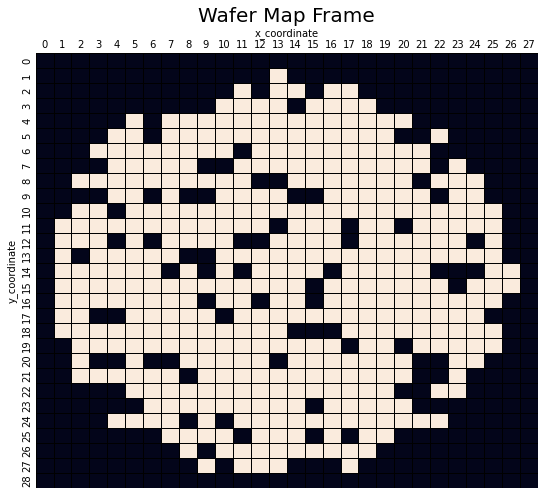

In [18]:
def visualization_wafer(map, size, title):
    plt.figure(figsize=(size+1,size))
    ax = sns.heatmap(map, linewidths=1, linecolor='black', cbar=False)
    plt.xlabel("x_coordinate")
    plt.ylabel("y_coordinate")  
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.title(title, fontsize=20)
    plt.show()
    
visualization_wafer(base_wafer, 8, "Wafer Map Frame")

In [19]:
defectList = []
for fp in path_list:
    cnt = 0
    filename = os.path.splitext(os.path.basename(fp))[0]
    for line in readfile(fp):
        if line[1] == 'DefectList':
            cnt += 1
            
        elif cnt > 0 and line[1].isnumeric():
            tempList = [filename]
            tempList.append(line[1])
            tempList.extend(line[4:6])
            defectList.append(tempList)
            
        elif line[1] == 'SummarySpec':
            break
        
        else:
            continue

defectCols = ['FILE', 'DEFECTID', 'XINDEX', 'YINDEX']
defect_df = pd.DataFrame(defectList, columns=defectCols)
defect_df[["XINDEX", "YINDEX"]] = defect_df[["XINDEX", "YINDEX"]].applymap(lambda x: 0 if x==None else int(x))
defect_df.head()

,FILE,DEFECTID,XINDEX,YINDEX
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,1,16,6
1,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,2,16,6
2,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,3,16,6
3,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,4,16,6
4,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,5,16,6


In [20]:
defectList = []
for fp in path_list:
    cnt = 0
    filename = os.path.splitext(os.path.basename(fp))[0]
    for line in readfile(fp):
        if line[1] == 'DefectList':
            defectRow = int(line[0])
            cnt += 1
            
        elif line[1] == 'DefectRecordSpec':
            defectColsNum = len(line[3:])
            
        elif cnt > 0 and line[1].isnumeric():
            tempList = [filename]
            tempList.append(line[1])
            tempList.extend(line[4:6])
            defectList.append(tempList)
            
        elif line[1] == 'SummarySpec':
            break
        
        else:
            continue
        
    if not readfile(fp)[defectRow][1].isnumeric():
        tempList = [filename]
        tempList.extend(np.zeros(3).tolist())
        defectList.append(tempList)
    
defectCols = ['FILE', 'DEFECTID', 'XINDEX', 'YINDEX']
defect_df = pd.DataFrame(defectList, columns=defectCols)
defect_df[["XINDEX", "YINDEX"]] = defect_df[["XINDEX", "YINDEX"]].applymap(lambda x: 0 if x==None else int(x))

In [21]:
defect_df[defect_df.DEFECTID == 0]

,FILE,DEFECTID,XINDEX,YINDEX
8965,T7HJ699TA_T7HJ699-01_2023-03-13_11.50.34,0.0,0,0
10350,T7HJ503T_T7HJ503-05_2023-03-13_11.44.46,0.0,0,0
10351,T7HJ503T_T7HJ503-05_2023-03-13_11.43.22,0.0,0,0
10352,T7HJ699TA_T7HJ699-06_2023-03-13_11.49.35,0.0,0,0
10353,T7HJ699TA_T7HJ699-02_2023-03-13_11.50.22,0.0,0,0
10356,T7HJ759TA_T7HJ759-25_2023-03-13_11.45.05,0.0,0,0
18423,T7HJ759TA_T7HJ759-03_2023-03-13_11.45.35,0.0,0,0
18424,T7HJ699TA_T7HJ699-04_2023-03-13_11.49.59,0.0,0,0
18425,T7HJ503T_T7HJ503-08_2023-03-13_11.43.48,0.0,0,0
18426,T7HJ699TA_T7HJ699-03_2023-03-13_11.50.12,0.0,0,0


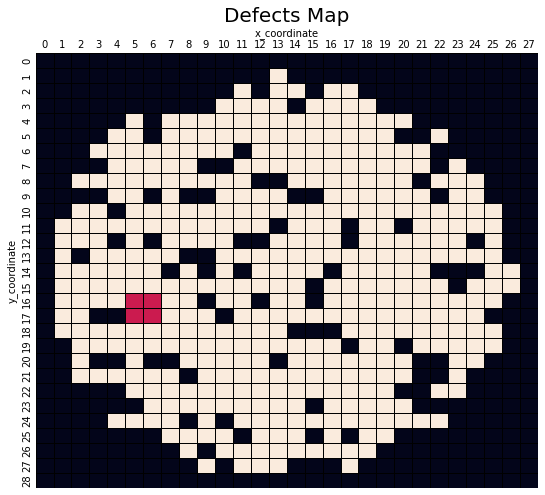

In [22]:
# defect 시각화
defectMaps=[]
for fp in path_list:
    base = base_wafer.copy()
    filename = os.path.splitext(os.path.basename(fp))[0]
    defect_x = defect_df[defect_df.FILE == filename][["XINDEX"]].astype('int').values
    defect_y = defect_df[defect_df.FILE == filename][["YINDEX"]].astype('int').values
    
    if (defect_x == 0).all():
        pass
    else:
        for i in range(defect_x.size):
            base[defect_x[i][0], defect_y[i][0]] = 0.5
    defectMaps.append(base)
    
# 임의의 defect map 시각화
visualization_wafer(defectMaps[0],8, "Defects Map")

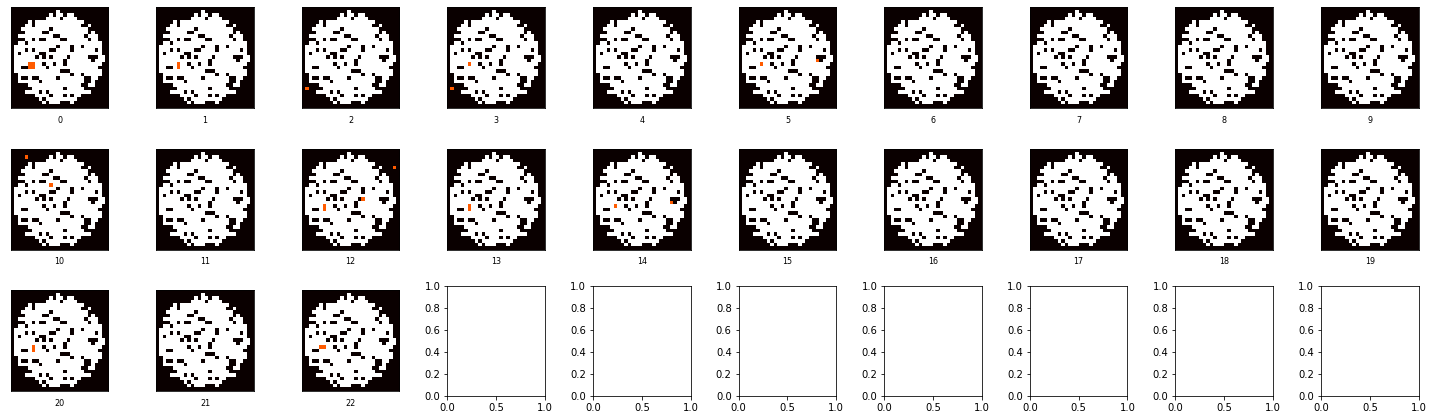

In [23]:
# 다중 wafer 시각화 (단순 추이를 보기 위함.)

fig, ax = plt.subplots(nrows=len(defectMaps)//10+1, ncols=10, figsize=(20,2*(len(defectMaps)//10+1)))
ax = ax.ravel(order='C')
for i in range((len(defectMaps)//10+1)*10):
    try:
        ax[i].imshow(defectMaps[i], cmap=cm.hot)
        ax[i].set_xlabel(f'{i}', fontsize=8)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    except:
        pass
plt.tight_layout()
plt.show()

## 분석용 데이터 생성

In [24]:
temp_df.head()

,filename,lotid,timestamp,machineid,stepid,deviceid
0,T7HJ503T_T7HJ503-09_2023-03-13_11.43.38,T7HJ503T,2023-02-26 02:03:33,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
1,T7HJ503T_T7HJ503-08_2023-03-13_11.43.48,T7HJ503T,2023-02-26 02:20:59,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
2,T7HJ503T_T7HJ503-06_2023-03-13_11.44.22,T7HJ503T,2023-02-26 02:38:07,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
3,T7HJ503T_T7HJ503-05_2023-03-13_11.44.46,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
4,T7HJ503T_T7HJ503-05_2023-03-13_11.43.22,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3


In [25]:
defect_df["map"] = defect_df[["XINDEX", "YINDEX"]].apply(list, axis=1)
defect_df.head(3)

,FILE,DEFECTID,XINDEX,YINDEX,map
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,1,16,6,"[16, 6]"
1,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,2,16,6,"[16, 6]"
2,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,3,16,6,"[16, 6]"


In [26]:
def appendFn(*listset):
    lst = []
    for list_ in listset:
        lst.append(list_)
    return lst

defect_temp = defect_df.groupby(['FILE'])["map"].apply(appendFn).reset_index()
defect_temp.map = defect_temp.map.apply(lambda x: np.array(x).squeeze(0))
defect_temp

,FILE,map
0,T7HJ400T_T7HJ400-21_2023-03-13_11.47.30,"[[16, 6], [16, 6], [16, 6], [16, 6], [16, 6], ..."
1,T7HJ400T_T7HJ400-22_2023-03-13_11.46.49,"[[16, 6], [16, 6], [16, 6], [16, 6], [16, 6], ..."
2,T7HJ400T_T7HJ400-23_2023-03-13_11.46.34,"[[16, 6], [16, 6], [16, 6], [16, 6], [16, 6], ..."
3,T7HJ400T_T7HJ400-23_2023-03-13_11.47.06,"[[16, 6], [16, 6], [16, 6], [16, 6], [16, 6], ..."
4,T7HJ400T_T7HJ400-24_2023-03-13_11.46.12,"[[5, -2], [14, -11], [16, 6], [16, 6], [16, 6]..."
5,T7HJ400T_T7HJ400-25_2023-03-13_11.45.59,"[[16, 6], [16, 6], [16, 6], [16, 6], [16, 6], ..."
6,T7HJ503T_T7HJ503-05_2023-03-13_11.43.22,"[[0, 0]]"
7,T7HJ503T_T7HJ503-05_2023-03-13_11.44.46,"[[0, 0]]"
8,T7HJ503T_T7HJ503-06_2023-03-13_11.44.22,"[[2, 4], [10, 11]]"
9,T7HJ503T_T7HJ503-08_2023-03-13_11.43.48,"[[0, 0]]"


In [27]:
df = pd.merge(temp_df, defect_temp, how='inner', left_on='filename', right_on='FILE').drop(columns=["FILE", "filename"])
df.head()

,lotid,timestamp,machineid,stepid,deviceid,map
0,T7HJ503T,2023-02-26 02:03:33,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
1,T7HJ503T,2023-02-26 02:20:59,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
2,T7HJ503T,2023-02-26 02:38:07,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[2, 4], [10, 11]]"
3,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
4,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"


In [28]:
df

,lotid,timestamp,machineid,stepid,deviceid,map
0,T7HJ503T,2023-02-26 02:03:33,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
1,T7HJ503T,2023-02-26 02:20:59,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
2,T7HJ503T,2023-02-26 02:38:07,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[2, 4], [10, 11]]"
3,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
4,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
5,T7HJ759TA,2023-02-26 21:27:10,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
6,T7HJ759TA,2023-02-26 21:43:09,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
7,T7HJ759TA,2023-02-26 21:43:09,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]"
8,T7HJ400T,2023-02-27 00:08:16,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[16, 6], [16, 6], [16, 6], [16, 6], [16, 6], ..."
9,T7HJ400T,2023-02-27 00:23:44,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[5, -2], [14, -11], [16, 6], [16, 6], [16, 6]..."


In [29]:
# hyperparameter
class cfg:
    seed = 1234
    n_window = 3 # 한 batch에 확인할 wafer 수 -> 10
    origin = [(base_wafer.shape[0]-1)/2, (base_wafer.shape[1]-1)/2]

In [30]:
# batch dataset visualization v2
def dist(origin, defects):
    if defects[0] == [0,0]:
        return [-1]
    distance = [-1]
    for i in range(len(defects)):
        dist = 0
        for j in range(len(defects[i])):
            dist += (origin[j]-defects[i][j])**2
        dist **= 1/2
        distance.append(int(dist))
    return distance

def theta(origin, defects):
    if defects[0] == [0,0]:
        return [-180]
    theta = [-180]
    for i in range(len(defects)):
        rc_x = defects[i][0] - origin[0]
        rc_y = defects[i][1] - origin[1]
        ang = int(np.rad2deg(np.arctan2(rc_y, rc_x)))
        theta.append(ang) # 가시성을 위해 rad -> deg
    return theta

df["distance"] = df.map.apply(lambda x:dist(cfg.origin, x))
df["degree"] = df.map.apply(lambda x:theta(cfg.origin, x))

df.head(30)

,lotid,timestamp,machineid,stepid,deviceid,map,distance,degree
0,T7HJ503T,2023-02-26 02:03:33,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]",[-1],[-180]
1,T7HJ503T,2023-02-26 02:20:59,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]",[-1],[-180]
2,T7HJ503T,2023-02-26 02:38:07,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[2, 4], [10, 11]]","[-1, 15, 4]","[-180, -141, -147]"
3,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]",[-1],[-180]
4,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]",[-1],[-180]
5,T7HJ759TA,2023-02-26 21:27:10,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]",[-1],[-180]
6,T7HJ759TA,2023-02-26 21:43:09,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]",[-1],[-180]
7,T7HJ759TA,2023-02-26 21:43:09,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[0, 0]]",[-1],[-180]
8,T7HJ400T,2023-02-27 00:08:16,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[16, 6], [16, 6], [16, 6], [16, 6], [16, 6], ...","[-1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,...","[-180, -75, -75, -75, -75, -75, -75, -75, -75,..."
9,T7HJ400T,2023-02-27 00:23:44,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3,"[[5, -2], [14, -11], [16, 6], [16, 6], [16, 6]...","[-1, 17, 24, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[-180, -120, -90, -75, -75, -75, -75, -75, -75..."


In [31]:
def batch_graph(degree, distance, graph=True):
    intp = interpolate.interp1d(degree, distance, kind='linear') # linear, cubic, nearest ...
    xnew = np.arange(min(degree), max(degree), 0.1)
    
    if graph:
        fig = plt.figure(figsize=(5,2))
        plt.plot(degree, distance, "ro", xnew, intp(xnew))
        plt.xlim([-180, -180+360*cfg.n_window])
        plt.ylim([0, 20])
        xtick = np.array(degree) % 360
        plt.xticks(degree, xtick, rotation=45)
        plt.show()
    return intp, xnew

# FFT graph
def fft_graph(input, graph=True):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    freq = np.fft.fftfreq(len(Y), 1/1000)

    amp = amp[0:20]
    freq = freq[0:20]
    
    if graph:
        plt.figure(figsize=(5,2))
        plt.stem(freq, amp)
        plt.grid(True)
        plt.show()
    return amp

In [32]:
# 전체 데이터에 대해 진행.
def amp_data(input):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    return amp[0:20]

In [33]:
# fft그래프 visualization
def visualization_graph(df, case, graph=True):
    df["Case"] = case
    nRows = len(df) - cfg.n_window + 1
    for i in range(nRows):
        df_dist = df.distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
        df_deg = df.degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        batch_dist.append(-1)    
        batch_deg.append(-180 + 360*(n+1))    
            
        print(f"Index_{df.at[i+cfg.n_window-1, 'index']}")
        intp, xnew = batch_graph(batch_deg, batch_dist, graph)
        fft_graph(intp(xnew), graph)
    return 

In [ ]:
# fft후, amplitude 값 컬럼 추가
def add_amplitude(df):
    nRows = len(df) - cfg.n_window + 1
    for i in tqdm(range(nRows)):
        df_dist = df.distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
            
        df_deg = df.degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        
        intp, xnew = batch_graph(batch_deg, batch_dist, False)
        df.at[i+cfg.n_window-1,"amplitude"] = amp_data(intp(xnew)).astype('object')
    return df

In [35]:
# amplitude, case 컬럼 추가
machine_type = df["machineid"].unique()
step_type = df["stepid"].unique()
device_type = df["deviceid"].unique()

temp_df = pd.DataFrame()
case = 0
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            print(f"Case{case}: {m,s,d}")
            temp = df[(df.machineid == m) & (df.stepid == s) & (df.deviceid == d)].reset_index()
            if len(temp) == 0:
                print("데이터프레임 없음")
                continue
            
            temp = add_amplitude(temp)
            temp['case'] = case
            temp_df = pd.concat([temp_df, temp], axis=0)
#temp_df = temp_df.sort_values(by='index').reset_index(drop=True)

Case1: ('FIB M10C2D01', 'WAFER_REFLOW_INSP3', 'V7H_REFLOW_INSP3')


NameError: name 'add_amplitude' is not defined

In [34]:
temp_df

,filename,lotid,timestamp,machineid,stepid,deviceid
0,T7HJ503T_T7HJ503-09_2023-03-13_11.43.38,T7HJ503T,2023-02-26 02:03:33,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
1,T7HJ503T_T7HJ503-08_2023-03-13_11.43.48,T7HJ503T,2023-02-26 02:20:59,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
2,T7HJ503T_T7HJ503-06_2023-03-13_11.44.22,T7HJ503T,2023-02-26 02:38:07,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
3,T7HJ503T_T7HJ503-05_2023-03-13_11.44.46,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
4,T7HJ503T_T7HJ503-05_2023-03-13_11.43.22,T7HJ503T,2023-02-26 02:55:08,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
5,T7HJ759TA_T7HJ759-25_2023-03-13_11.45.05,T7HJ759TA,2023-02-26 21:27:10,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
6,T7HJ759TA_T7HJ759-03_2023-03-13_11.45.18,T7HJ759TA,2023-02-26 21:43:09,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
7,T7HJ759TA_T7HJ759-03_2023-03-13_11.45.35,T7HJ759TA,2023-02-26 21:43:09,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
8,T7HJ400T_T7HJ400-25_2023-03-13_11.45.59,T7HJ400T,2023-02-27 00:08:16,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3
9,T7HJ400T_T7HJ400-24_2023-03-13_11.46.12,T7HJ400T,2023-02-27 00:23:44,FIB M10C2D01,WAFER_REFLOW_INSP3,V7H_REFLOW_INSP3


In [35]:
data = temp_df[["amplitude", "case"]]
    
# null값 제거
data = data[data.amplitude.notnull()]
data

,amplitude,case
2,"[1.618708827406256, 0.3801544778482997, 0.3767...",1
3,"[5.537500000000429, 5.937801619340802, 2.80237...",1
4,"[5.537500000000429, 5.937801619340802, 2.80237...",1
5,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
6,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
7,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
8,"[0.4132387706873035, 1.5475284779893037, 1.434...",1
9,"[7.700841346153376, 5.226753897749032, 2.44891...",1
10,"[11.536177884615133, 3.2789675651912984, 3.509...",1
11,"[9.256129807691927, 2.600244911591237, 4.84818...",1


In [36]:
# Class 라벨 추가
klarf_info = pd.read_csv("./klarf_scenario.txt", sep='\t')
klarf_info[klarf_info.Class != 0] = 1
temp_class = data.copy()
temp_class["class"] = klarf_info.Class
temp_class

,amplitude,case,class
2,"[1.618708827406256, 0.3801544778482997, 0.3767...",1,0
3,"[5.537500000000429, 5.937801619340802, 2.80237...",1,0
4,"[5.537500000000429, 5.937801619340802, 2.80237...",1,0
5,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0
6,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0
7,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0
8,"[0.4132387706873035, 1.5475284779893037, 1.434...",1,0
9,"[7.700841346153376, 5.226753897749032, 2.44891...",1,0
10,"[11.536177884615133, 3.2789675651912984, 3.509...",1,0
11,"[9.256129807691927, 2.600244911591237, 4.84818...",1,0


In [37]:
def make_amplitude_df(df):
    arr = np.array(df.amplitude.iloc[0]).reshape(1,-1)
    cols = np.array([i for i in range(arr.shape[1])])
    idx = df.index
    for i in range(1,len(df)):
        arr = np.append(arr, df.amplitude.iloc[i].reshape(1,-1), axis=0)
        
    df = pd.DataFrame(arr, columns=cols, index=idx)
    return df
make_amplitude_df(temp_class)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2,1.618709,0.380154,0.376762,0.371169,0.363462,0.353767,0.342238,0.329063,0.314459,0.298672,0.281971,0.264651,0.24703,0.229443,0.212244,0.1958,0.180479,0.166642,0.15461,0.144632
3,5.5375,5.937802,2.802373,1.57431,1.324041,0.877044,0.803872,0.577642,0.531093,0.410616,0.366225,0.308384,0.264757,0.245087,0.207416,0.206897,0.180156,0.183976,0.168896,0.168901
4,5.5375,5.937802,2.802373,1.57431,1.324041,0.877044,0.803872,0.577642,0.531093,0.410616,0.366225,0.308384,0.264757,0.245087,0.207416,0.206897,0.180156,0.183976,0.168896,0.168901
5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.413239,1.547528,1.434655,1.262128,1.051803,0.831767,0.63482,0.494864,0.430499,0.420592,0.422863,0.41175,0.383666,0.348117,0.318704,0.303807,0.300699,0.299754,0.293275,0.279695
9,7.700841,5.226754,2.448919,4.456298,2.235441,2.381478,2.22354,1.16459,1.243404,0.79586,0.583654,0.681083,0.411002,0.686108,0.447512,0.443821,0.439748,0.169466,0.306804,0.113508
10,11.536178,3.278968,3.509411,3.613824,1.972553,2.29322,1.617612,1.119703,0.659526,0.86867,0.115418,0.795042,0.176943,0.653192,0.365072,0.32828,0.503034,0.203682,0.436149,0.154062
11,9.25613,2.600245,4.848186,0.772211,1.658164,1.255437,1.39574,1.331822,1.118346,0.726049,0.701623,0.410791,0.208459,0.222799,0.335147,0.443165,0.430638,0.461133,0.347962,0.321564
